In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import models
import utils

from mltools.networks import networks
from mltools.utils import cuda_tools
from mltools import ml_utils

device=cuda_tools.get_freer_device()

import importlib
importlib.reload(models)
importlib.reload(utils)

memory_available [78565]
best GPU: 0


<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/utils.py'>

In [14]:
#config_path="./data/images_1/circle_noxy_inis=0.3/seed=0/seed=0.yaml"
#config_path="./data/images_1/2x2x2/base/seed=0/seed=0.yaml"
config_paths=["./data/images_1/2x2/fcfs_fast/seed=0/seed=0.yaml",
"./data/images_1/2x2/fcns_fast/seed=0/seed=0.yaml",
"./data/images_1/2x2/ncfs_fast/seed=0/seed=0.yaml",
"./data/images_1/2x2/ncns_fast/seed=0/seed=0.yaml",
]
config_paths=["./data/images_1/2x2_final/fcfs_fast/seed=0/seed=0.yaml",
"./data/images_1/2x2_final/ncfs_fast/seed=0/seed=0.yaml",
]
config_paths=["./data/images_1/2x2_final/fcfs_2/seed=0/seed=0.yaml",
"./data/images_1/2x2_final/ncfs_2/seed=0/seed=0.yaml",
]
config_paths=["./data/images_1/2x2_final2/sc4ss4/sep_col=0.2_sep_size=0.1/seed=0/seed=0.yaml",
"./data/images_1/2x2_final2/sc4ss4/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml",
"./data/images_1/2x2_final2/sc3ss2_snarrow/sep_col=0.2_sep_size=0.2/seed=0/seed=0.yaml",
"./data/images_1/2x2_final2/sc3ss2_snarrow/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml"
]
#config_paths=["./data/images_1/2x2x2_final/sc2ss2sb2/sep_col=0.2_sep_size=0.2_sep_bg_col=0.2/seed=0/seed=0.yaml",
#"./data/images_1/2x2x2_final/sc2ss2sb2/sep_col=0.6_sep_size=0.35_sep_bg_col=0.6/seed=0/seed=0.yaml",
#]

n_tr=4096//len(config_paths)
n_test=256//len(config_paths)
batch_size=64
out_dim=11

x_tr=[]
y_tr=[]
x_te=[]
y_te=[]
for config_path in config_paths:
    config=utils.load_config(config_path)
    n_classes=config["data_params"]["n_classes"]
    config["n_samples_train"]=np.full(n_classes,n_tr)
    config["n_samples_test"]=np.full(n_classes,n_test)
    x_tr_,y_tr_,_,x_te_,y_te_,_=utils.generate_data(config)
    x_tr.append(x_tr_)
    y_tr.append(y_tr_)
    x_te.append(x_te_)
    y_te.append(y_te_)
x_tr=torch.tensor(np.concatenate(x_tr,axis=0),dtype=torch.float32).to(device)
y_tr=torch.tensor(np.concatenate(y_tr,axis=0),dtype=torch.float32).to(device)
x_te=torch.tensor(np.concatenate(x_te,axis=0),dtype=torch.float32).to(device)
y_te=torch.tensor(np.concatenate(y_te,axis=0),dtype=torch.float32).to(device)


In [15]:
x_tr.shape,y_tr.shape,x_te.shape,y_te.shape

(torch.Size([16384, 3, 32, 32]),
 torch.Size([16384, 11]),
 torch.Size([1024, 3, 32, 32]),
 torch.Size([1024, 11]))

In [16]:
train_ds=torch.utils.data.TensorDataset(x_tr,y_tr)
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_ds=torch.utils.data.TensorDataset(x_te,y_te)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [17]:
net=networks.CUNet(shape=(3,32,32),out_channels=64,chs=[32,32,32],norm_groups=4)
classifier=models.Classifier(net=net,out_dim=out_dim)
classifier=classifier.to(device)
optimizer=torch.optim.AdamW(classifier.parameters(),lr=1e-3)
classifier.optimizer=optimizer

In [18]:
def batch_to_kwargs(batch):
    x,l=batch
    x=x.to(device)
    l=l.to(device)
    return {"x":x,"l":l}
train_results=ml_utils.train(model=classifier,dl_tr=train_dl,dl_val=test_dl,
device=device,callback_steps=[],callbacks=[],n_steps=10000,batch_to_kwargs=batch_to_kwargs)

Training: 100%|██████████| 10000/10000 [01:44<00:00, 95.77it/s]


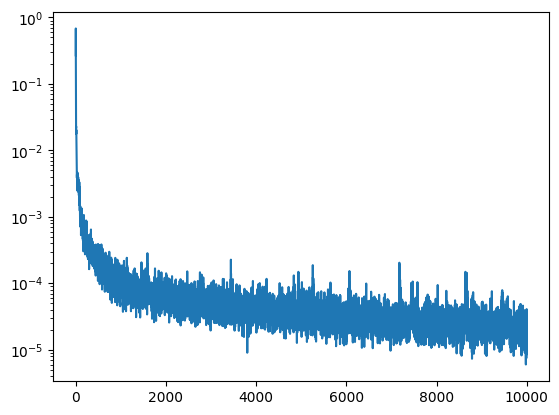

In [19]:
plt.plot(train_results["online_losses"])
plt.yscale("log")

In [20]:
mse_tot=0
with torch.no_grad():
    classifier.eval()
    for x,l in test_dl:
        x=x.to(device)
        l=l.to(device)
        mse_tot+=classifier.get_loss(x,l).item()
mse_tot/=len(test_dl)
mse_tot

1.579802395212937e-05

In [21]:
#torch.save(classifier.state_dict(),"./data/images_1/2x2x2/classifier.pth")
#torch.save(classifier.state_dict(),"./data/images_1/2x2/classifier_combined.pth")
#torch.save(classifier.state_dict(),"./data/images_1/2x2_final/classifier_2.pth")
torch.save(classifier.state_dict(),"./data/images_1/2x2_final2/regressor_combined.pth")
#torch.save(classifier.state_dict(),"./data/images_1/2x2x2_final/re_combined.pth")

In [27]:
classifier_memo="""
net=networks.CUNet(shape=(3,32,32),out_channels=64,chs=[32,32,32],norm_groups=4)
classifier=models.Classifier(net=net,n_classes=[2,2,2,2])
classifier=classifier.to(device)
"""
with open("./data/images_1/circle_noxy_inis=0.3/classifier_memo.txt","w") as f:
    f.write(classifier_memo)
torch.save(classifier.state_dict(),"./data/images_1/circle_noxy_inis=0.3/classifier.pth")

In [176]:
len(classifier.classify(x))

3

In [172]:
classes[2],classes_pred[2]

(tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
         0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
         0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
         0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
         0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0'))

In [150]:
l.shape

torch.Size([64])

In [140]:
net(torch.randn(64,3,32,32).to(device)).shape

torch.Size([64, 64, 32, 32])

In [105]:
next(iter(train_dl))[0].shape

torch.Size([64, 3, 32, 32])

In [88]:
xshape

torch.Size([32768, 3, 32, 32])

In [41]:
classifier.classify(torch.rand(1,3,32,32).to(device))

[tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0')]

In [ ]:
classifier_ckpt_path="./"